In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

import config as cfg

Config.py using existing local data directory /mnt/disks/disk-1/data/resnet


In [9]:
batch_size = 64
image_size = 224
# model_name = 'stage-8-256-rn50-exported'
model_name = 'rn34-stage1-v1'
resnet = models.resnet34
metrics = {'train': {}, 'validation': {}, 'test': {}}

In [4]:
train = pd.read_csv(os.path.join(cfg.csv_dir, 'train_upsampled_multilabel.csv'))
validation = pd.read_csv(os.path.join(cfg.csv_dir, 'validation_multilabel.csv'))
train['imagename'] = train['imagename'].map(lambda x: f"train/{x}")
validation['imagename'] = validation['imagename'].map(lambda x: f"validation/{x}")
df = pd.concat([train, validation])
df.reset_index(inplace=True, drop=True)

assert df.shape[0] == train.shape[0] + validation.shape[0]

In [5]:
test = pd.read_csv(os.path.join(cfg.csv_dir, 'test_multilabel.csv'))

In [6]:
# np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = (ImageList.from_df(path=cfg.img_path, df=df)
       .split_by_idx(valid_idx=range(train.shape[0], df.shape[0]))
       .label_from_df(cols='label', label_delim=' '))

src_test = (ImageList.from_df(path=cfg.img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [7]:
data = (src.transform(tfms, size=image_size)
        .databunch().normalize(imagenet_stats))

data_test = (src_test.transform(tfms, size=image_size)
        .databunch().normalize(imagenet_stats))

acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, resnet, metrics=[acc_05, f_score])

In [10]:
learn = learn.load(os.path.join(cfg.models_dir, model_name))

In [11]:
train_preds, train_y, train_losses = learn.get_preds(ds_type=DatasetType.Train, with_loss=True)

In [12]:
valid_preds, valid_y, valid_losses = learn.get_preds(with_loss=True)

In [13]:
torch.save(train_preds, os.path.join(cfg.output_path, f'{model_name}_train_preds.pt'))
torch.save(train_y, os.path.join(cfg.output_path, f'{model_name}_train_y.pt'))
torch.save(train_losses, os.path.join(cfg.output_path, f'{model_name}_train_losses.pt'))

torch.save(valid_preds, os.path.join(cfg.output_path, f'{model_name}_valid_preds.pt'))
torch.save(valid_y, os.path.join(cfg.output_path, f'{model_name}_valid_y.pt'))
torch.save(valid_losses, os.path.join(cfg.output_path, f'{model_name}_valid_losses.pt'))
           

In [14]:
metrics['train']['losses_mean'] = train_losses.mean().item()
metrics['validation']['losses_mean'] = valid_losses.mean().item()
print(metrics)

{'train': {'losses_mean': 0.07823006808757782}, 'validation': {'losses_mean': 0.0950462743639946}, 'test': {}}


In [15]:
def calc_single_metric_score(y, preds, metrics=[]):
    output = {}
    for metric in metrics:
        output[metric.__name__] = metric(y, preds)
    
    return(output)

# def calc_threshold_metric_score(y, preds, metrics=[], thresholds=np.arange(.05, 1, 0.05)):
    
#     for threshold_i in thresholds:
        
    
    
    
    

In [16]:
# from sklearn.metrics import accuracy_score
# threshold = 0.5
# metrics['test'][f'accuracy_overall_@{threshold}'] = accuracy_score(y, preds > threshold)

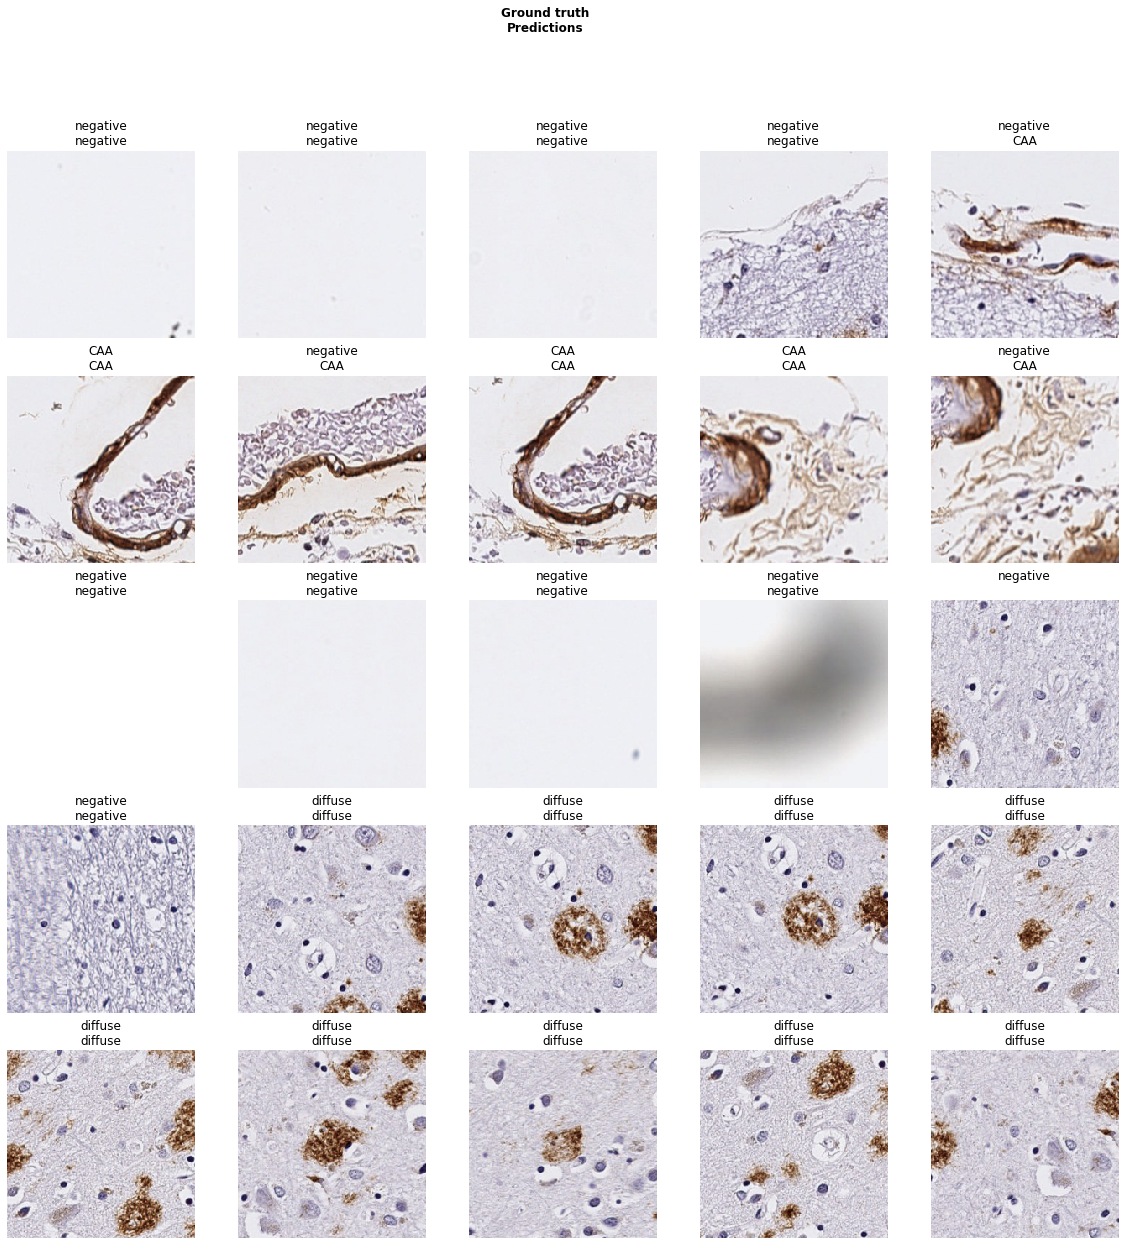

In [17]:
learn.show_results()

In [18]:
def losses_to_df(losses):
    l = losses.numpy()
    losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/4), 4)), columns=learn.data.classes)
    return(losses_df)

train_losses_df = losses_to_df(train_losses)
valid_losses_df = losses_to_df(valid_losses)

saved
saved


KeyError: 'validaiton'

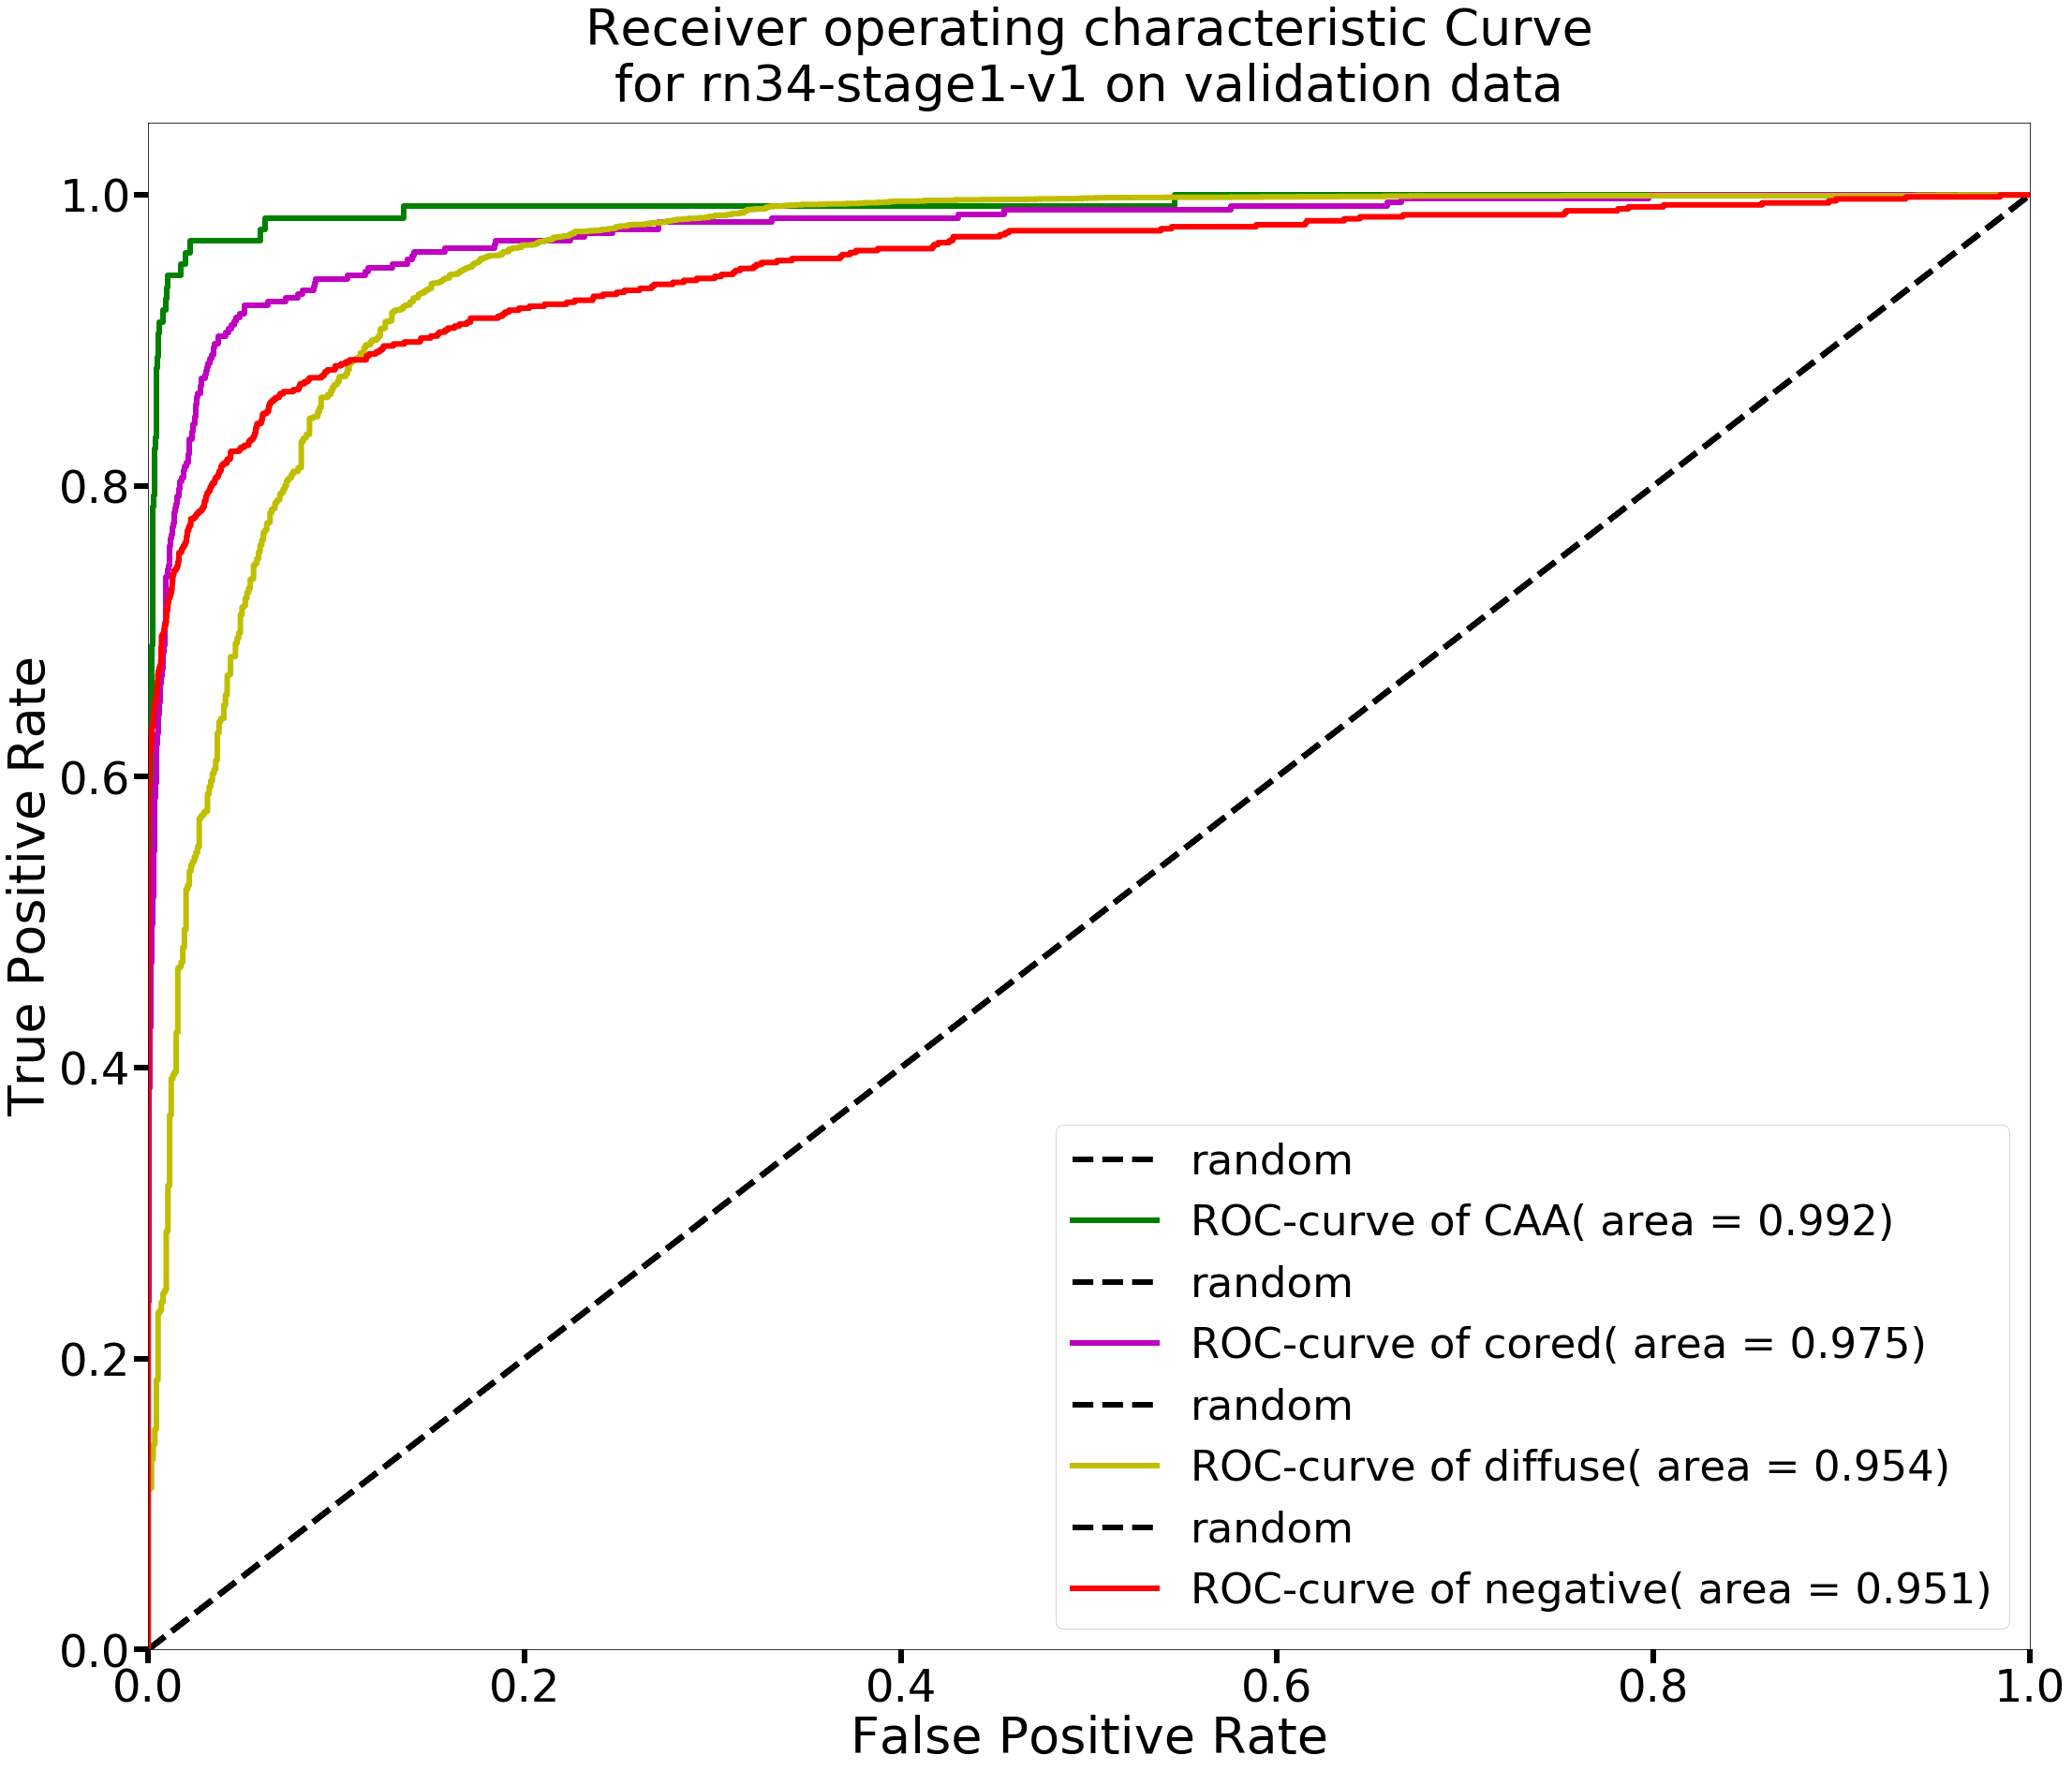

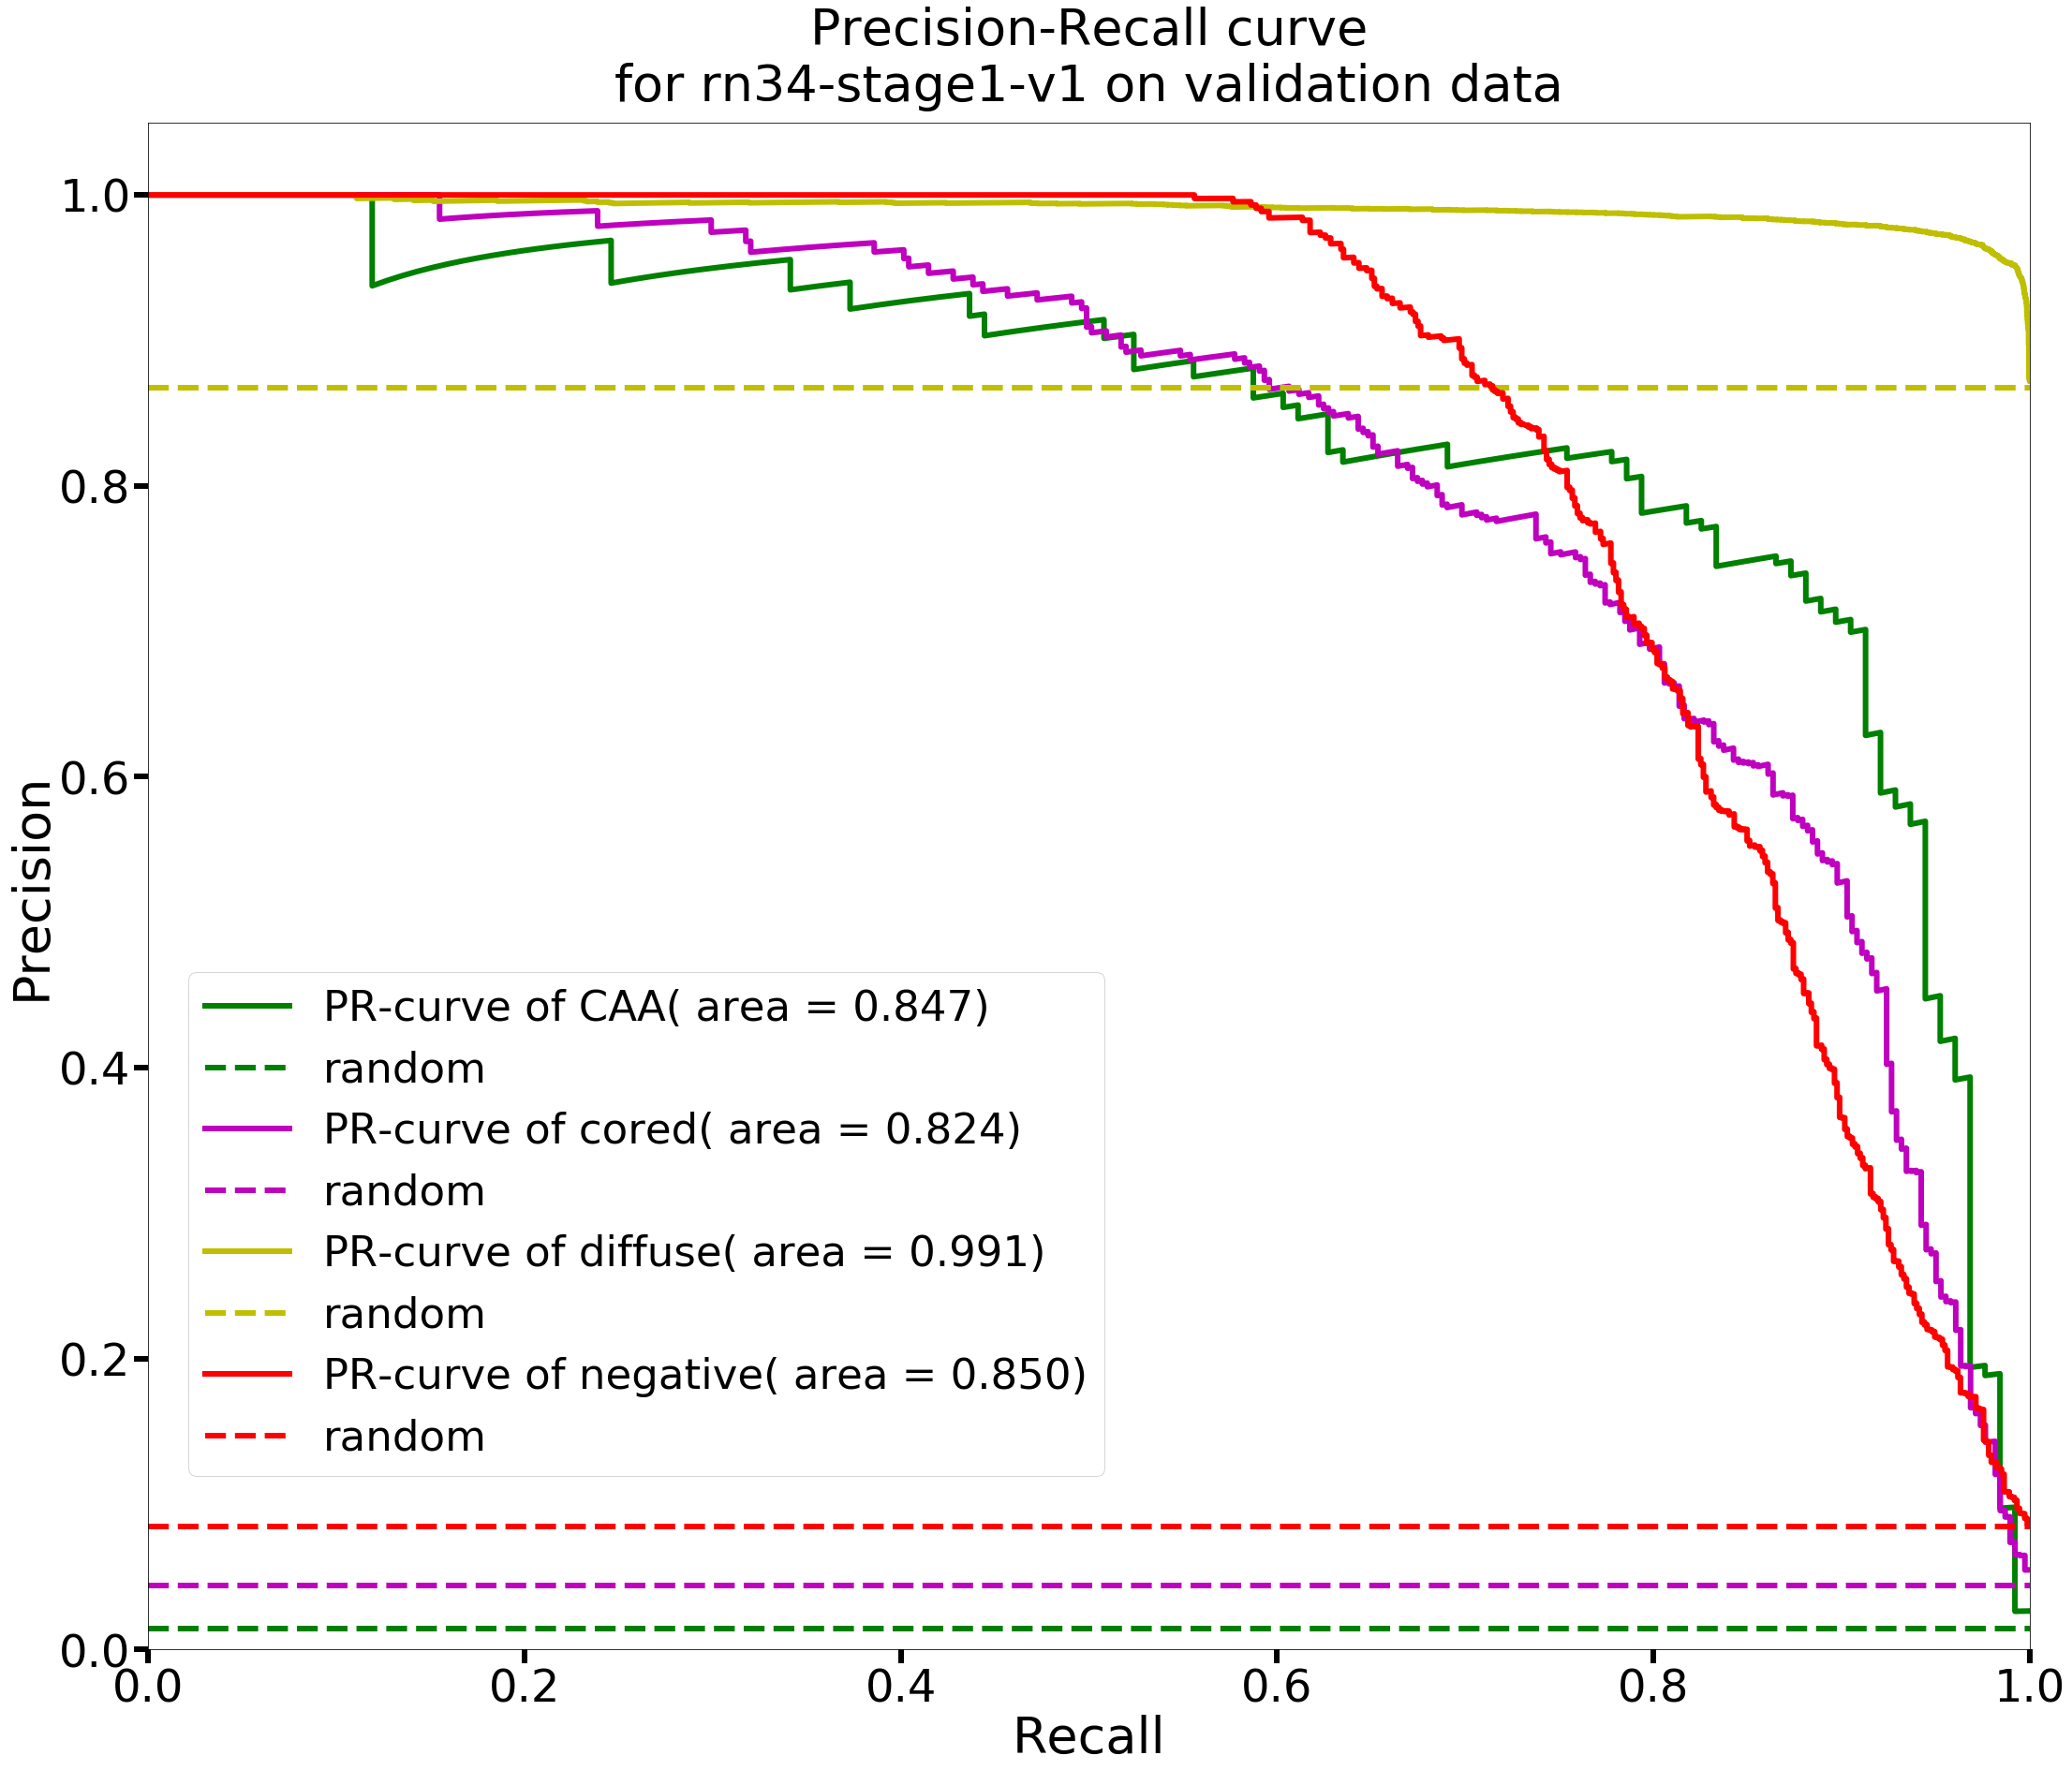

In [19]:
from utils import plot
roc = plot.roc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot.png'),
         model_name=model_name, dataset='validation')
prc = plot.prc(valid_preds.numpy(), valid_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot.png'),
         model_name=model_name, dataset='validation')

metrics['validaiton'] = {**metrics['validaiton'], **roc, **prc}

## Test Set

In [20]:
learn.data.valid_dl = data_test.train_dl
learn.validate(metrics=[acc_05, f_score])

[0.059877634, tensor(0.9807), tensor(0.9711)]

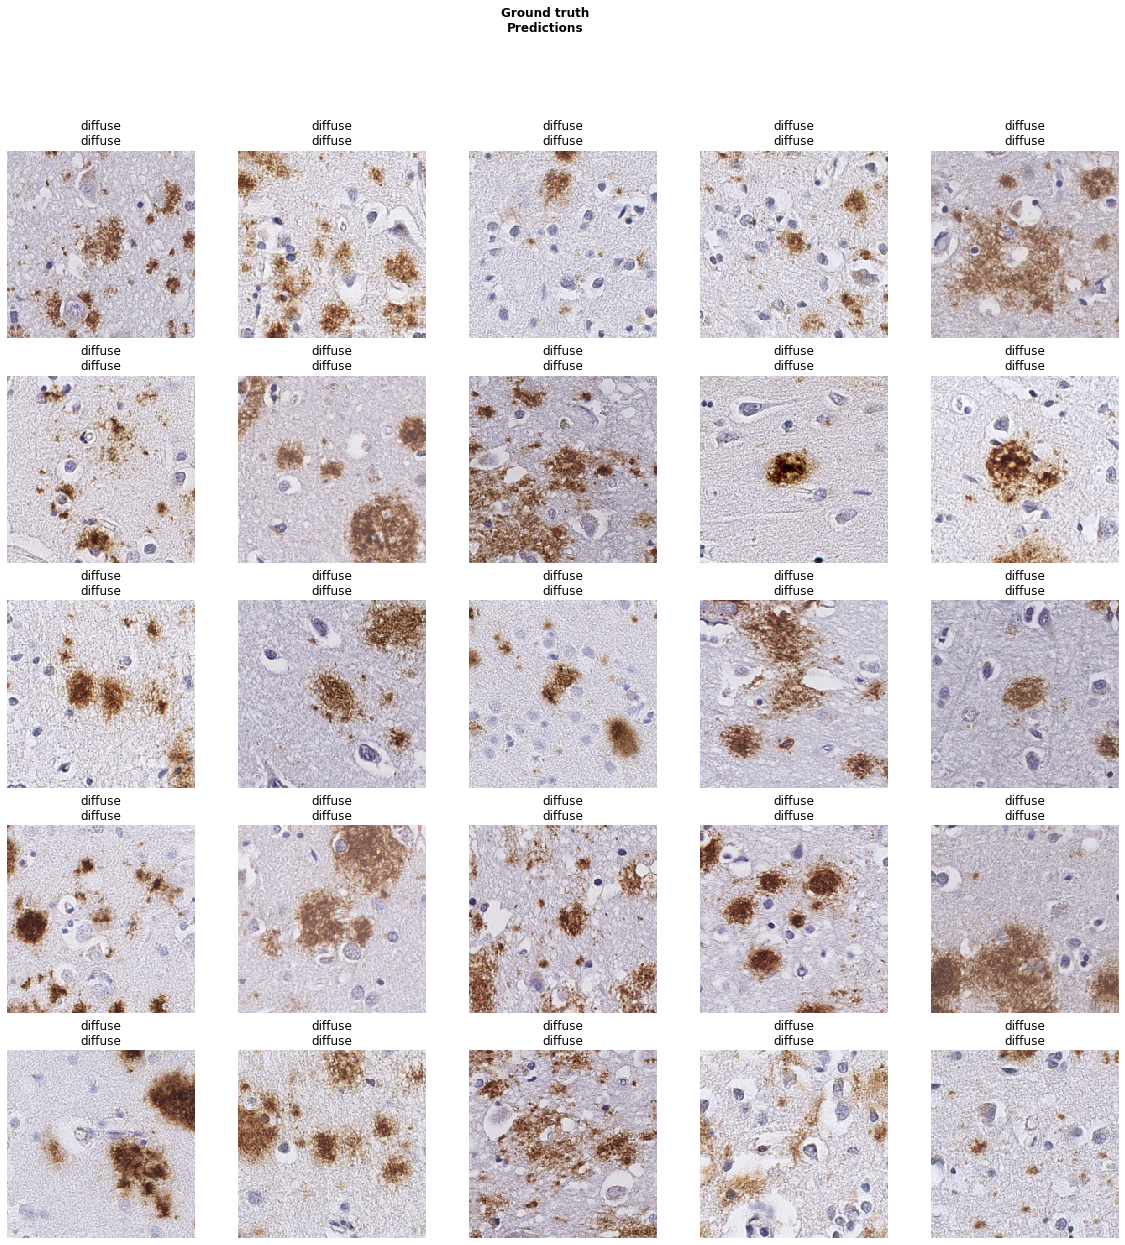

In [21]:
learn.show_results()

In [22]:
test_preds, test_y, test_losses = learn.get_preds(with_loss=True)

In [23]:
torch.save(test_preds, os.path.join(cfg.output_path, f'{model_name}_test_preds.pt'))
torch.save(test_y, os.path.join(cfg.output_path, f'{model_name}_test_y.pt'))
torch.save(test_losses, os.path.join(cfg.output_path, f'{model_name}_test_losses.pt'))

saved
saved


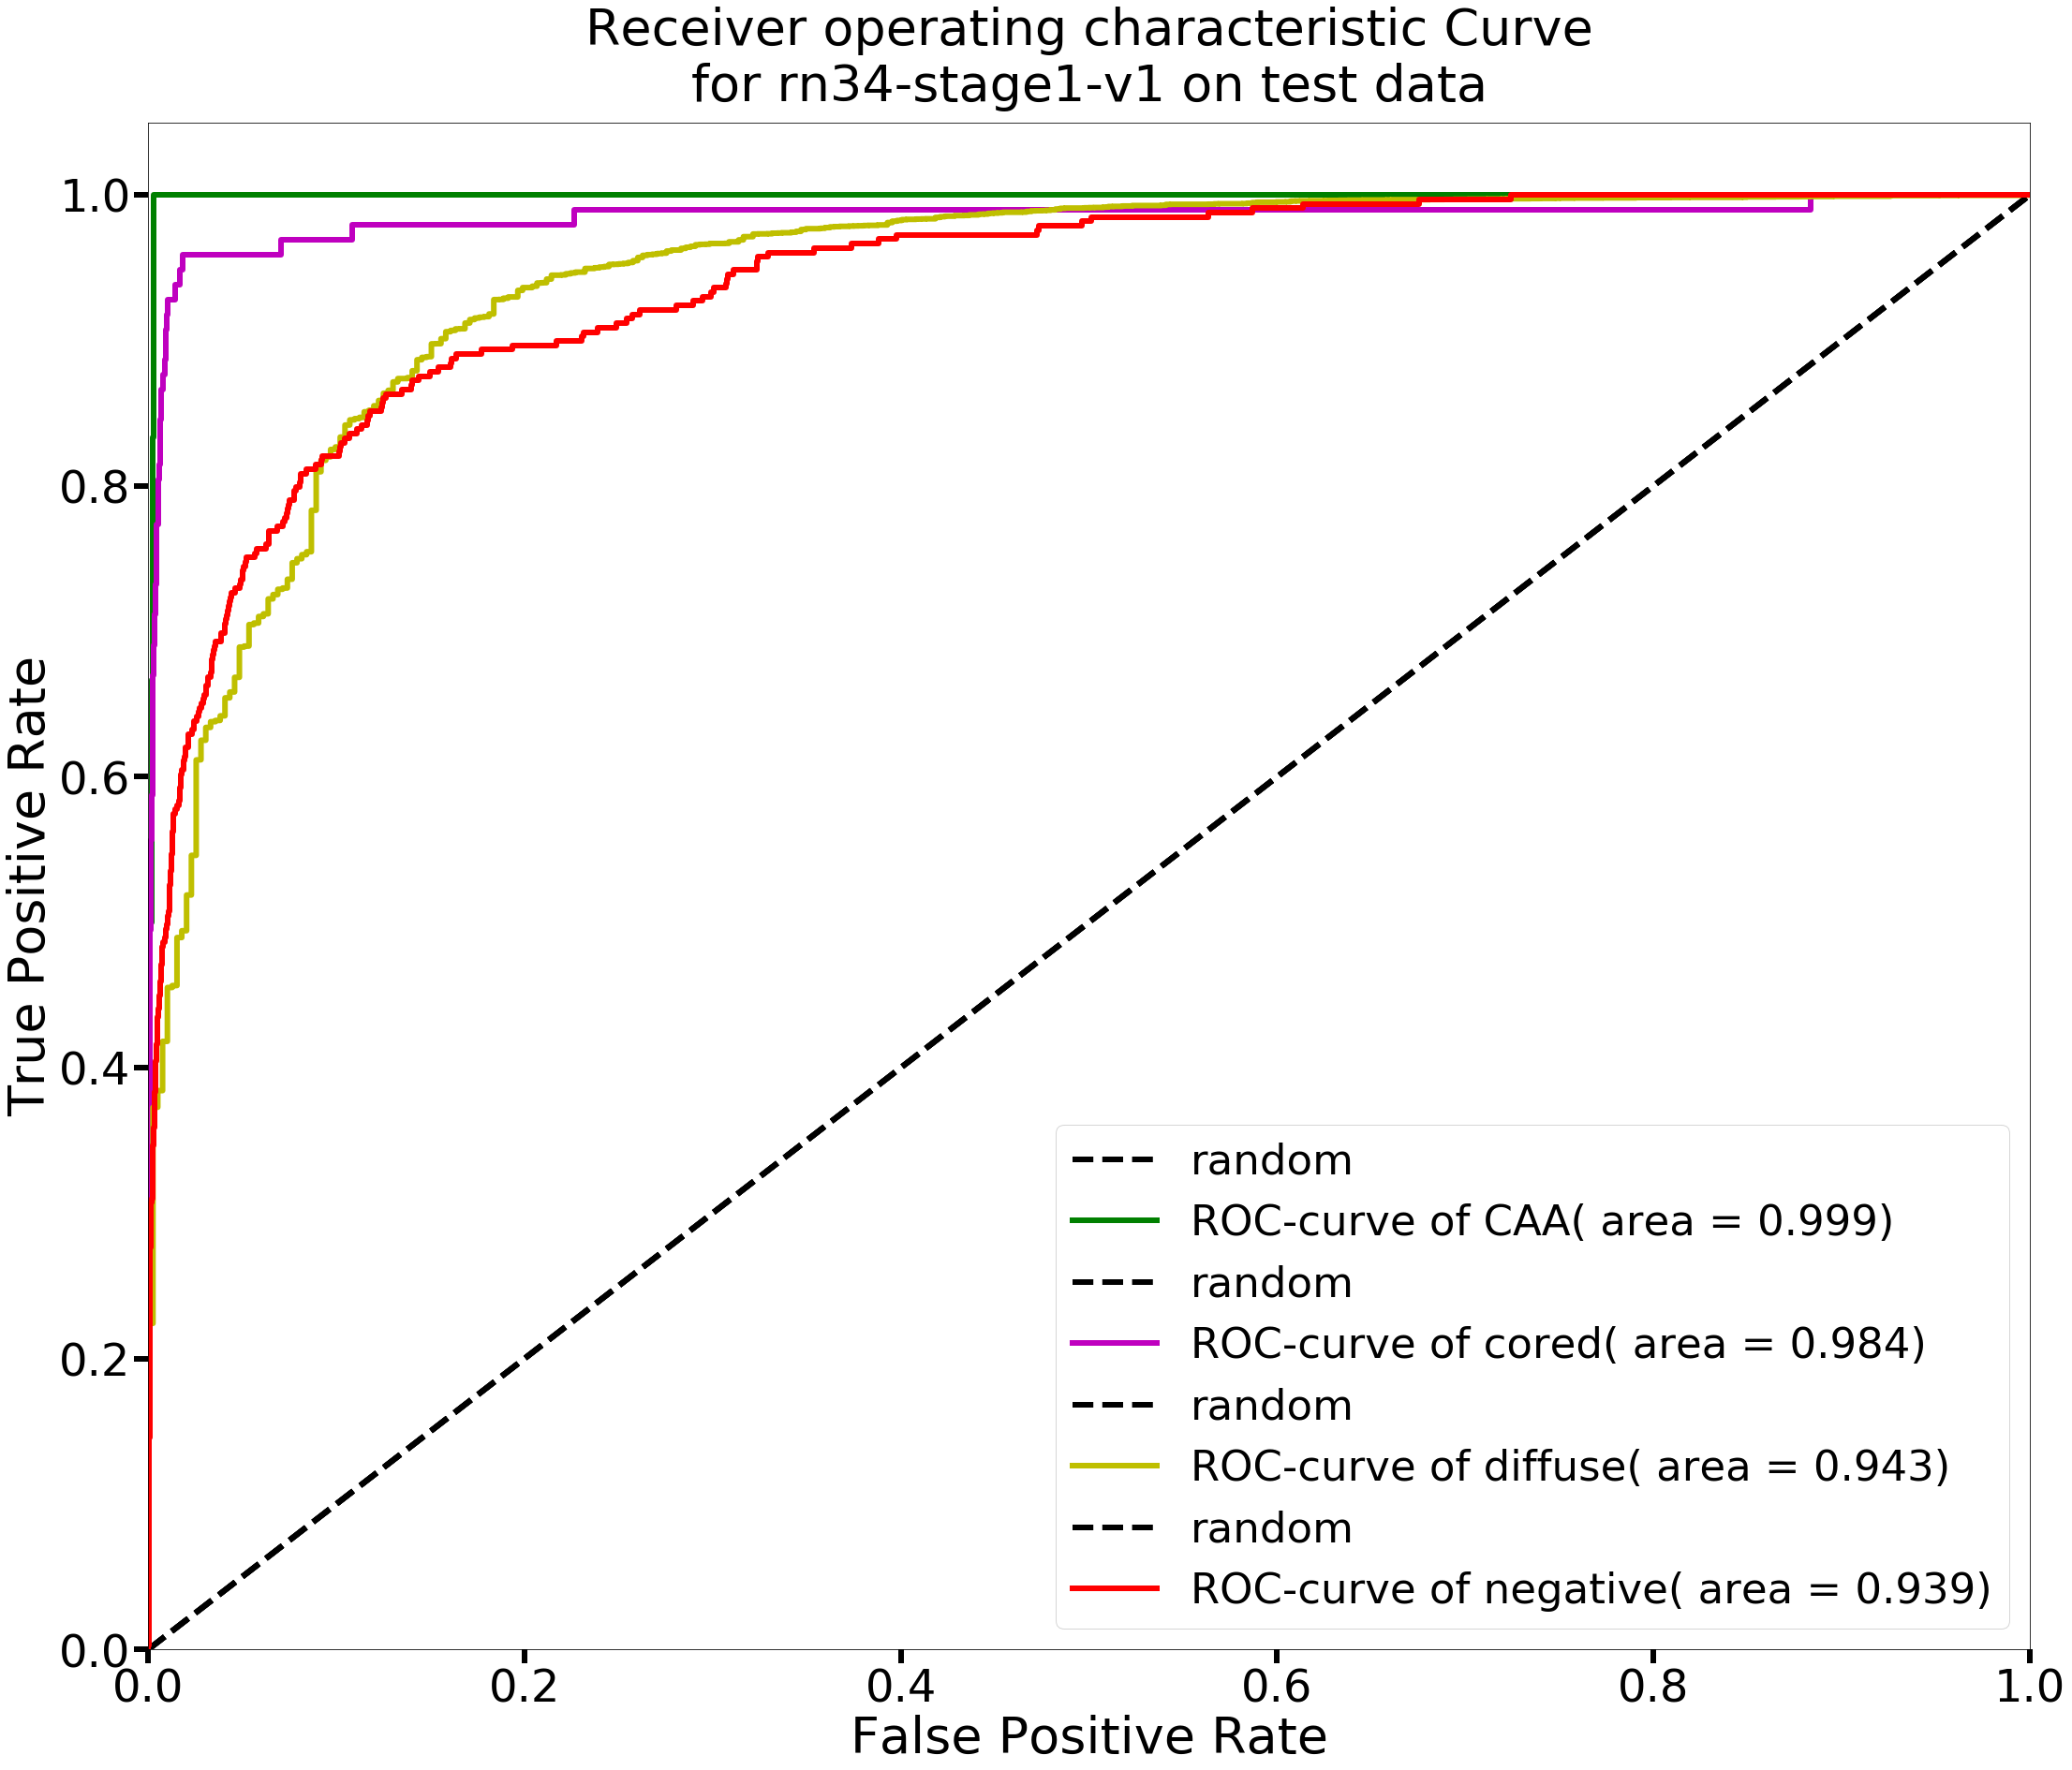

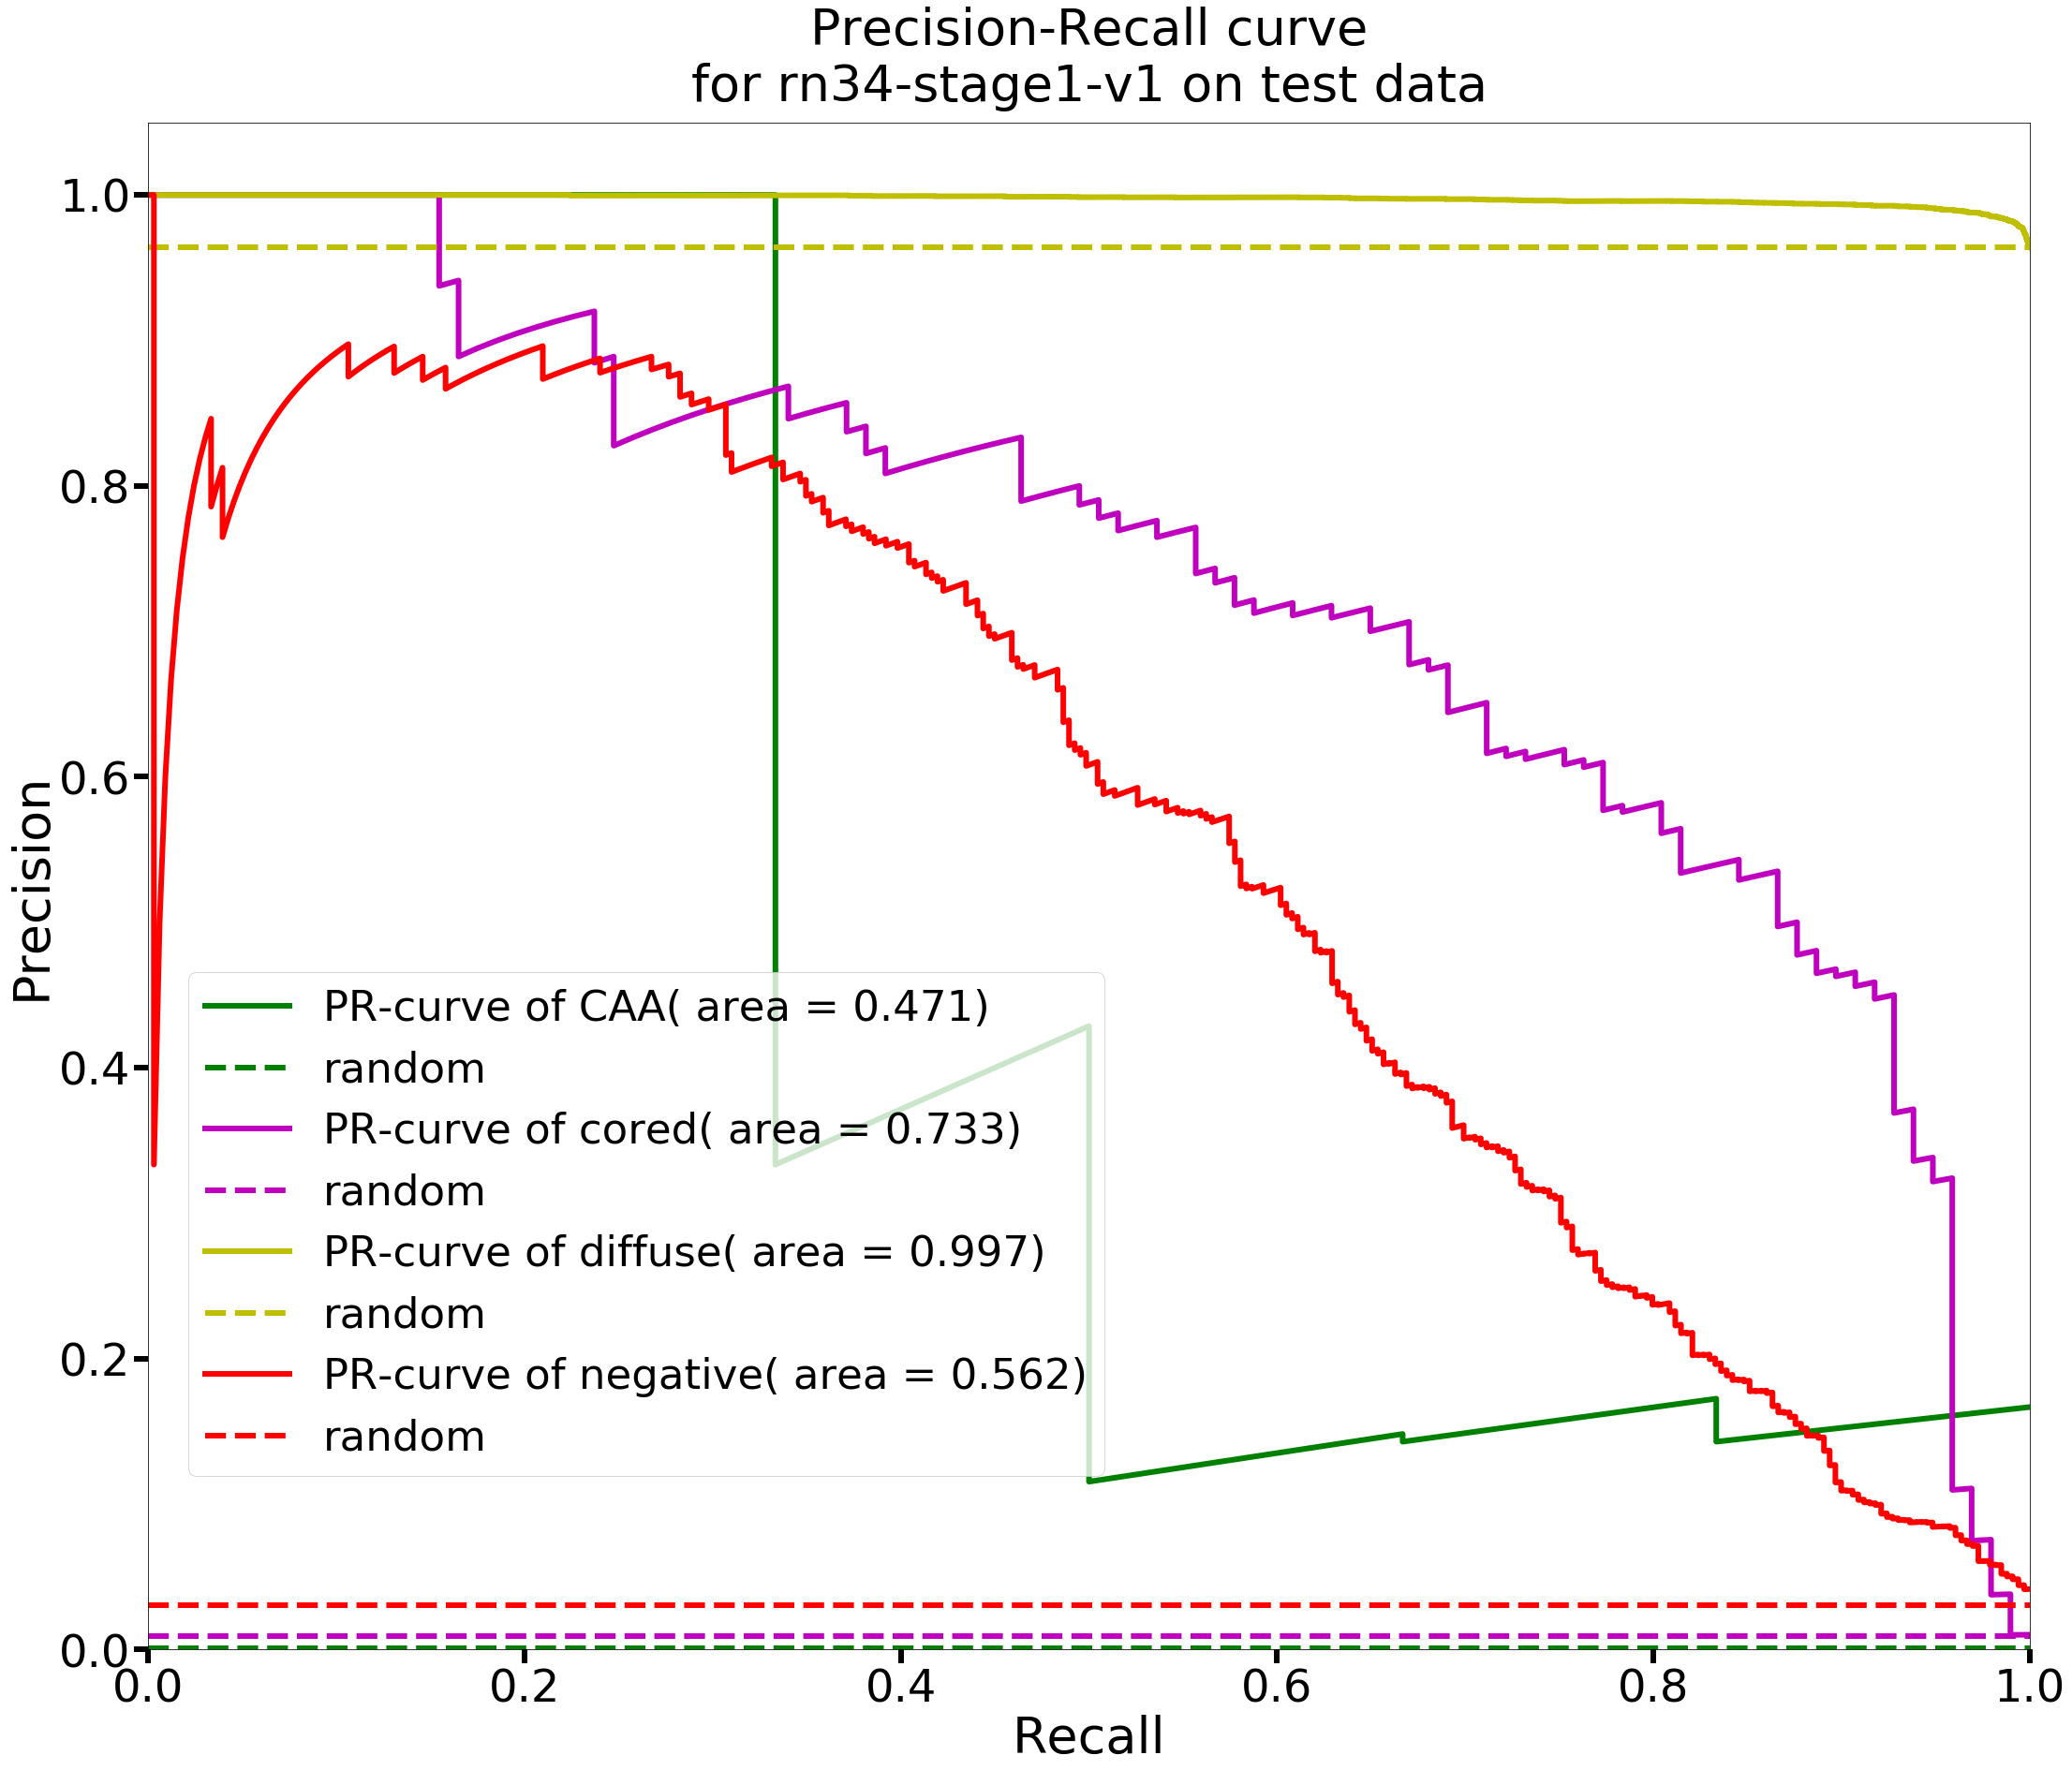

In [24]:
roc = plot.roc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_roc_plot_test.png'),
         model_name=model_name, dataset='test')
prc = plot.prc(test_preds.numpy(), test_y.numpy(), learn.data.classes, size=30,
         path=os.path.join(cfg.models_dir, f'{model_name}_prc_plot_test.png'),
         model_name=model_name, dataset='test')
metrics['test'] = {**metrics['test'], **roc, **prc}

In [26]:
def losses_reshape(losses, classes=[]):
    l = losses.numpy()
    n_classes = len(classes)
    losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/n_classes), n_classes)),
                             columns=classes)
    return(losses_df)

def get_top_agg_losses(df, n=10, target_class=None):
    
    if not target_class:
        target_class = 'loss'
    
    df['loss'] = pd.DataFrame(df.sum(axis=1), columns=['loss'])
    df = df.sort_values([target_class], ascending=False)
    
    return(df.iloc[0:n])

def plot_top_losses(preds=None,
                    y=None,
                    losses=None,
                    learner=None,
                    target_class=None,
                    n=10,
                    figsize=(256,256)):
    classes=learn.data.classes
    losses_df = losses_reshape(losses, classes=classes)
    losses_df = get_top_agg_losses(losses_df, n=n, target_class=target_class)
    preds_df = pd.DataFrame(preds.numpy(), columns=classes)
    y_df = pd.DataFrame(y.numpy(), columns=classes)
    classes_str = ', '.join(classes)
    
    fig, ax = plt.subplots(n, figsize=figsize)
    i = 0
    for index_i in losses_df.index:
        imag = learner.data.valid_ds[index_i][0]
        predictions =', '.join(["{0:.4f}".format(x) for x in preds_df.iloc[index_i].values])
        actuals = ', '.join(["{}".format(x) for x in y_df.iloc[index_i].values])
        title = f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}"""
        imag.show(ax=ax[i], title=title)
        i += 1
#         plt.imshow(imag)
#         ax[i].imshow(imag)
#         ax[i].set_title(title)
#         imag.set_title(f"""Classes: {classes_str}\nPredicted: {predictions}\nActual: {actuals}\nImage Index: {index_i}""",
#                         loc='left')
    plt.show()
        
    
    return(losses_df)
    
    
    

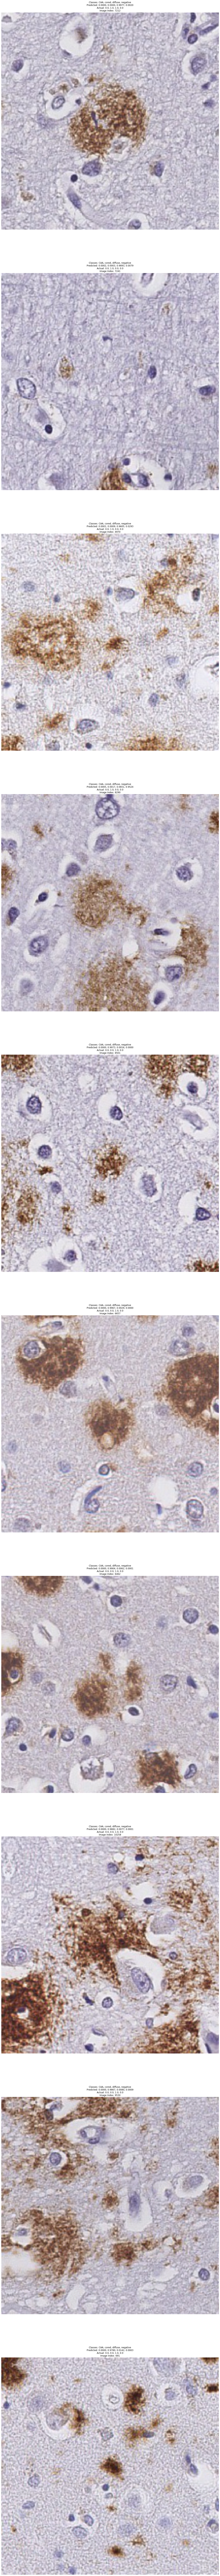

CAA      cored   diffuse  negative       loss
7212   3.850386e-05  12.368341  0.002295  0.002027  12.372702
7241   2.280214e-04   8.069903  4.534430  0.007913  12.612473
4970   8.964137e-05   6.985676  3.231570  0.029754  10.247089
8290   4.713616e-04   6.369632  0.067349  3.045805   9.483257
8501   8.344647e-07   5.900737  6.460532  0.000041  12.361311
6657   1.072883e-06   5.716428  5.835279  0.000021  11.551729
6462   3.099437e-06   4.646012  5.085055  0.000054   9.731124
10258  4.649151e-06   4.435720  4.860955  0.000062   9.296742
9530   2.050379e-05   4.316526  4.829323  0.000945   9.146814
691    1.204007e-05   3.817927  4.253573  0.000339   8.071851

In [28]:
plot_top_losses(preds=test_preds,
                y=test_y,
                losses=test_losses,
                learner=learn,
                target_class='cored')

In [ ]:
y = y.numpy()
ppreds.numpy()

In [49]:
from sklearn.metrics import accuracy_score
threshold = 0.5
metrics['test'][f'accuracy_overall_@threshold_{threshold}'] = accuracy_score(y, preds > threshold)

In [50]:
for class_idx in range(0, len(learn.data.classes)):
    name = f'accuracy_{learn.data.classes[class_idx]}_@threshold_{threshold}'
    metrics['test'][name] = accuracy_score(y[:,class_idx],
                                           preds[:,class_idx] > threshold)

In [59]:
from sklearn.metrics import f1_score
metrics['test'][f'f1_score_overall_@threshold{threshold}'] = f1_score(y, preds > threshold, average='micro')

In [60]:
metrics

{'train': {},
 'validaiton': {},
 'test': {'overall_accuracy': 0.9575628698224852,
  'accuracy_overall_threshold_0.5': 0.9575628698224852,
  'accuracy_cored_threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_threshold_0.5': 0.9689349112426036,
  'accuracy_CAA_threshold_0.5': 0.9975961538461539,
  'accuracy_negative_threshold_0.5': 0.978180473372781,
  'accuracy_overall_@threshold_0.5': 0.9575628698224852,
  'accuracy_CAA_@threshold_0.5': 0.9975961538461539,
  'accuracy_cored_@threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_@threshold_0.5': 0.9689349112426036,
  'accuracy_negative_@threshold_0.5': 0.978180473372781,
  'f1_score_overall_@threshold{threshold}': 0.9646420525081613,
  'f1_score_overall_@threshold0.5': 0.9646420525081613}}

In [62]:
from sklearn.metrics import hamming_loss

metrics['test'][f'hamming_loss_overall_@threshold_{threshold}'] = hamming_loss(y, preds > threshold)

In [63]:
metrics

{'train': {},
 'validaiton': {},
 'test': {'overall_accuracy': 0.9575628698224852,
  'accuracy_overall_threshold_0.5': 0.9575628698224852,
  'accuracy_cored_threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_threshold_0.5': 0.9689349112426036,
  'accuracy_CAA_threshold_0.5': 0.9975961538461539,
  'accuracy_negative_threshold_0.5': 0.978180473372781,
  'accuracy_overall_@threshold_0.5': 0.9575628698224852,
  'accuracy_CAA_@threshold_0.5': 0.9975961538461539,
  'accuracy_cored_@threshold_0.5': 0.9841900887573964,
  'accuracy_diffuse_@threshold_0.5': 0.9689349112426036,
  'accuracy_negative_@threshold_0.5': 0.978180473372781,
  'f1_score_overall_@threshold{threshold}': 0.9646420525081613,
  'f1_score_overall_@threshold0.5': 0.9646420525081613,
  'hamming_loss_overall_@threshold0.5': 0.017774593195266274}}